# Abstractive Text Summarization using sequence-to-sequence (seq2seq) model with attention mechanisms

### AIM:
To Design and abstractive text summarization system using a deep learning
sequence-to-sequence (seq2seq) model with attention mechanisms. The
model should generate concise, meaningful summaries of news articles
from the CNN/DailyMail dataset, achieving a ROUGE-1 score of at least 0.35
on the test set.

#### Installing Necessary packages

In [1]:
  !pip install datasets transformers rouge-score tensorflow numpy matplotlib tqdm sentencepiece evaluate torch --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.2 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=5bf4b3dad4016bb9091b1c37519aecbb0629509a559356538c38e5e9e328743f
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score


### Data Preparation

#### Loading the Dataset

In [2]:
from datasets import load_dataset

dataset = load_dataset("cnn_dailymail", "3.0.0")

dataset

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

3.0.0/train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

3.0.0/train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

3.0.0/train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

3.0.0/validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

3.0.0/test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

#### Splitting Train, Validation and Test Set

In [3]:
train_raw = dataset["train"]
val_raw = dataset["validation"]
test_raw = dataset["test"]

print('Sample article:')
print(train_raw[0]['article'])
print()
print('Sample highlights:')
print(train_raw[0]['highlights'])

Sample article:
LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don't plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don't think I'll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office chart

#### Clean text
Removing special characters, lowercasing, and tokenizing.

In [4]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\(cnn\)', '', text)
    text = re.sub(r'--\s*', ' ', text)
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r"[^a-z0-9.,!?'\s]", ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

#### Splitting into articles (input) and highlights (target summaries).

In [5]:
MAX_INPUT_LEN = 400
MAX_TARGET_LEN = 100
TRAIN_SAMPLES = 1000
VAL_SAMPLES = 500
TEST_SAMPLES = 500

def extract_pairs(split, n):
    arts, summs = [], []
    for i in range(min(n, len(split))):
        art  = clean_text(split[i]['article'])
        summ = clean_text(split[i]['highlights'].replace('\n', ' '))
        if len(art.split()) > 10 and len(summ.split()) > 3:
            arts.append(art)
            summs.append(summ)
    return arts, summs

train_arts, train_summs = extract_pairs(train_raw, TRAIN_SAMPLES)
val_arts, val_summs = extract_pairs(val_raw, VAL_SAMPLES)
test_arts, test_summs = extract_pairs(test_raw, TEST_SAMPLES)

#### Article Length Distribution Visualization

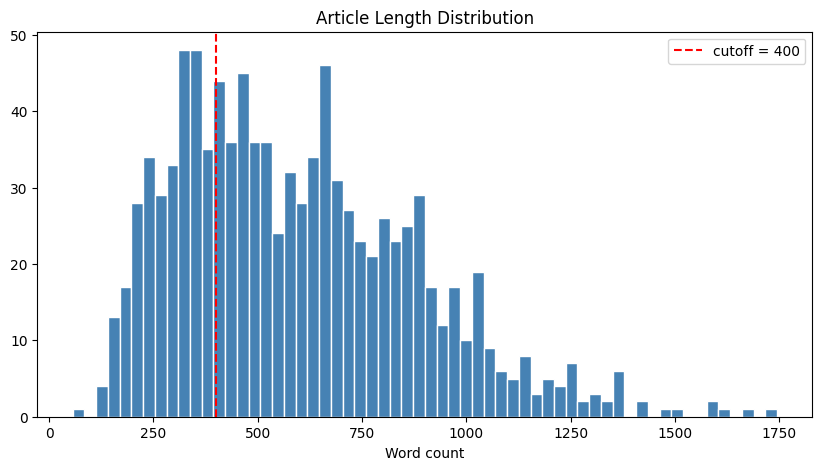

Articles mean: 594, max: 1745


In [6]:
import numpy as np
import matplotlib.pyplot as plt

art_lens = [len(art.split()) for art in train_arts]

plt.figure(figsize=(10, 5))
plt.hist(art_lens,  bins=60, color='steelblue', edgecolor='white')
plt.axvline(MAX_INPUT_LEN,  color='red', ls='--', label=f'cutoff = {MAX_INPUT_LEN}')
plt.title('Article Length Distribution')
plt.xlabel('Word count')
plt.legend()
plt.show()

print(f'Articles mean: {np.mean(art_lens):.0f}, max: {max(art_lens)}')

#### Summary Length Distribution Visualization

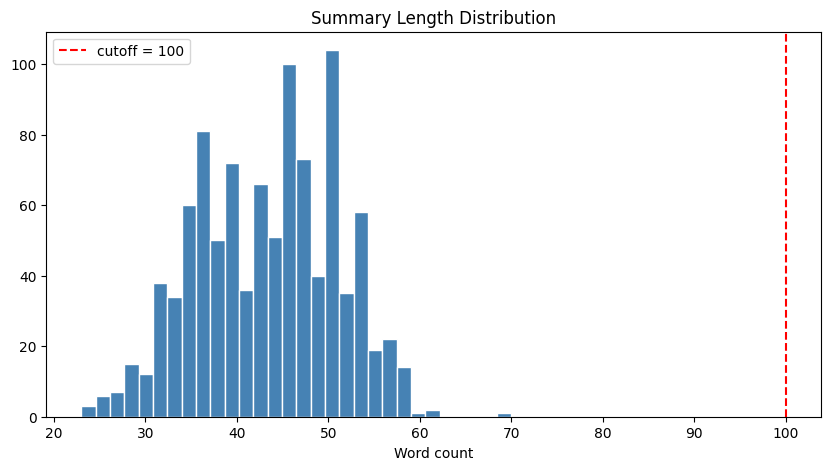

Summaries mean: 43, max: 70


In [7]:
summ_lens = [len(summ.split()) for summ in train_summs]

plt.figure(figsize=(10, 5))
plt.hist(summ_lens, bins=30, color='steelblue', edgecolor='white')
plt.axvline(MAX_TARGET_LEN, color='red', ls='--', label=f'cutoff = {MAX_TARGET_LEN}')
plt.title('Summary Length Distribution')
plt.xlabel('Word count')
plt.legend()
plt.show()

print(f'Summaries mean: {np.mean(summ_lens):.0f}, max: {max(summ_lens)}')

#### Building Vocabulary
Building word-to-index mappings for input and target,
with `<PAD>`, `<UNK>`, `<SOS>`, and `<EOS>` tokens

In [8]:
from collections import Counter
from tqdm import tqdm

VOCAB_SIZE = 10000
MIN_FREQ = 2

PAD, UNK, SOS, EOS = '<PAD>', '<UNK>', '<SOS>', '<EOS>'

freq = Counter()
for text in tqdm(train_arts + train_summs, desc='counting tokens'):
    freq.update(text.split())

kept  = [w for w, c in freq.most_common() if c >= MIN_FREQ][:VOCAB_SIZE - 4]
vocab = [PAD, UNK, SOS, EOS] + kept

word2idx = {w: i for i, w in enumerate(vocab)}
idx2word = {i: w for w, i in word2idx.items()}

PAD_IDX = word2idx[PAD]
UNK_IDX = word2idx[UNK]
SOS_IDX = word2idx[SOS]
EOS_IDX = word2idx[EOS]
ACTUAL_VOCAB = len(vocab)

print(f'Vocabulary size : {ACTUAL_VOCAB:,}')
print(f'Special tokens PAD={PAD_IDX}, UNK={UNK_IDX}, SOS={SOS_IDX}, EOS={EOS_IDX}')

counting tokens: 100%|██████████| 2000/2000 [00:00<00:00, 5736.23it/s]


Vocabulary size : 10,000
Special tokens PAD=0, UNK=1, SOS=2, EOS=3


#### Text Encoding and Padding
Truncating/padding sequences to fixed lengths (400 tokens for input, 100 for
output). Each word is mapped to its corresponding index using a vocabulary dictionary. If a word is not found, it is replaced with a special `<UNK>` token to handle unknown words. Special tokens like `<SOS>` (start of sequence) and `<EOS>` (end of sequence) can be added to help the model understand when to begin and stop generating output. Shorter sequences are padded with <PAD> tokens at the end, while longer ones are truncated.

In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def encode_texts(texts, max_len, add_sos=False, add_eos=False):
    seqs = []
    for text in texts:
        ids = [word2idx.get(w, UNK_IDX) for w in text.split()]
        if add_sos:
            ids = [SOS_IDX] + ids
        if add_eos:
            ids = ids + [EOS_IDX]
        seqs.append(ids)
    return pad_sequences(seqs, maxlen=max_len, padding='post',
                         truncating='post', value=PAD_IDX)

#### Preparing Encoder and Decoder Data
Encoder inputs are the news articles, converted and padded to a fixed length for training, validation, and testing. Decoder inputs are the summaries with a `<SOS>` token added at the beginning. This tells the model where to start generating the summary. Decoder targets are the same summaries but with an `<EOS>` token added at the end. This represents the correct output the model should learn to produce.

In [10]:
enc_train = encode_texts(train_arts, MAX_INPUT_LEN)
enc_val = encode_texts(val_arts, MAX_INPUT_LEN)
enc_test = encode_texts(test_arts, MAX_INPUT_LEN)
dec_in_train  = encode_texts(train_summs, MAX_TARGET_LEN, add_sos=True)
dec_tgt_train = encode_texts(train_summs, MAX_TARGET_LEN, add_eos=True)
dec_in_val = encode_texts(val_summs, MAX_TARGET_LEN, add_sos=True)
dec_tgt_val = encode_texts(val_summs, MAX_TARGET_LEN, add_eos=True)

print(f'enc_train shape : {enc_train.shape}')
print(f'dec_in shape : {dec_in_train.shape}')
print(f'dec_target shape : {dec_tgt_train.shape}')

enc_train shape  : (1000, 400)
dec_in shape     : (1000, 100)
dec_target shape : (1000, 100)


#### Downloading and Extracting GloVe Embedding
Prepares the pre-trained word embeddings so they can be used to improve the model’s understanding of word meanings

In [11]:
import os
import zipfile
import urllib.request

GLOVE_URL = "https://nlp.stanford.edu/data/glove.6B.zip"
GLOVE_ZIP = "glove.6B.zip"
GLOVE_DIR = "glove"

if not os.path.exists(GLOVE_ZIP):
    print("Downloading GloVe embeddings...")
    urllib.request.urlretrieve(GLOVE_URL, GLOVE_ZIP)
    print("Download complete.")

if not os.path.exists(GLOVE_DIR):
    print("Extracting GloVe embeddings...")
    with zipfile.ZipFile(GLOVE_ZIP, 'r') as zip_ref:
        zip_ref.extractall(GLOVE_DIR)
    print("Extraction complete.")

Download complete.
Extracting GloVe embeddings...
Extraction complete.


#### Loading GloVe Embeddings
glove.6B.100d.txt is read line by line. Each line contains: word, 100-dimensional vector representation

For every word, its embedding vector is stored in a dictionary, where Key: Word, Value: Corresponding numerical vector

In [12]:
EMBED_DIM  = 100
GLOVE_PATH = 'glove/glove.6B.100d.txt'

glove = {}
with open(GLOVE_PATH, 'r', encoding='utf-8') as f:
    for line in tqdm(f, desc='loading GloVe'):
        parts = line.split()
        glove[parts[0]] = np.array(parts[1:], dtype=np.float32)

print(f'GloVe vocab : {len(glove):,} words')

loading GloVe: 400000it [00:10, 39026.27it/s]

GloVe vocab : 400,000 words


#### Creating the Embedding Matrix
Embedding matrix is created for the entire vocabulary. It is first initialized with random values, and the `<PAD>` token is set to zero so it does not influence training. Then, for each word in the vocabulary, if a matching GloVe embedding exists, its pre-trained vector replaces the random values. Words not found in GloVe keep their random initialization.

In [13]:
embedding_matrix = np.random.normal(scale=0.1, size=(ACTUAL_VOCAB, EMBED_DIM)).astype(np.float32)
embedding_matrix[PAD_IDX] = 0.0

found = 0
for word, idx in word2idx.items():
    if word in glove:
        embedding_matrix[idx] = glove[word]
        found += 1

print(f'Words matched in GloVe : {found} / {ACTUAL_VOCAB} ({100 * found / ACTUAL_VOCAB:.1f}%)')
print(f'Embedding matrix shape : {embedding_matrix.shape}')

Words matched in GloVe : 7584 / 10000 (75.8%)
Embedding matrix shape : (10000, 100)


#### Model Architecture
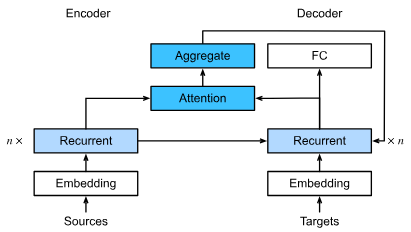

#### Bahdanau Attention Mechanism
Defines a custom Bahdanau Attention layer, which helps the decoder focus on the most relevant parts of the encoder’s output while generating each word of the summary. It compares the decoder’s current state with all encoder outputs to calculate attention scores. These scores are converted into weights that highlight relevant words in the input. A context vector is then created using these weights and passed to the decoder to improve prediction accuracy. A small test with dummy inputs confirms that the attention layer is working correctly.

In [14]:
import tensorflow as tf

class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.W_enc = tf.keras.layers.Dense(units, use_bias=False)
        self.W_dec = tf.keras.layers.Dense(units, use_bias=False)
        self.W_cov = tf.keras.layers.Dense(units, use_bias=False)
        self.V = tf.keras.layers.Dense(1,     use_bias=False)

    def call(self, dec_hidden, enc_outputs, coverage=None):
        dec_exp = tf.expand_dims(dec_hidden, 1)
        score = self.W_enc(enc_outputs) + self.W_dec(dec_exp)
        if coverage is not None:
            score += self.W_cov(coverage)
        score = self.V(tf.nn.tanh(score))
        weights = tf.nn.softmax(score, axis=1)
        context = tf.reduce_sum(weights * enc_outputs, axis=1)
        return context, weights

_a = BahdanauAttention(64)
_ctx, _w = _a(tf.zeros([2, 64]), tf.zeros([2, 20, 64]))
print(f'Attention context: {_ctx.shape}, weights: {_w.shape}')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'bahdanau_attention', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Attention context: (2, 64), weights: (2, 20, 1)


#### Encoder Architecture
Encoder reads the entire news article and converts it into meaningful numerical representations. words are transformed into vectors using the embedding layer. Dropout is applied to prevent overfitting. Then, a Bidirectional LSTM processes the sequence from both forward and backward directions, allowing the model to understand full context. The final forward and backward states are combined to create the hidden and cell states that initialize the decoder.

In [15]:
HIDDEN_UNITS = 300
DROPOUT_RATE = 0.3

class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embed_dim, hidden_units, dropout_rate, embed_matrix):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(
            vocab_size, embed_dim,
            embeddings_initializer=tf.keras.initializers.Constant(embed_matrix),
            trainable=True, mask_zero=False
        )
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.bilstm  = tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(hidden_units, return_sequences=True,
                                 return_state=True, dropout=dropout_rate)
        )
        self.proj_h = tf.keras.layers.Dense(hidden_units, activation='tanh')
        self.proj_c = tf.keras.layers.Dense(hidden_units, activation='tanh')

    def call(self, x, training=False):
        x = self.dropout(self.embedding(x), training=training)
        out, fh, fc, bh, bc = self.bilstm(x, training=training)
        h = self.proj_h(tf.concat([fh, bh], axis=-1))
        c = self.proj_c(tf.concat([fc, bc], axis=-1))
        return out, h, c

_enc = Encoder(ACTUAL_VOCAB, EMBED_DIM, HIDDEN_UNITS, DROPOUT_RATE, embedding_matrix)
_eo, _h, _c = _enc(tf.zeros([2, MAX_INPUT_LEN], dtype=tf.int32))
print(f'Encoder output: {_eo.shape}, h: {_h.shape}, c: {_c.shape}')

Encoder output: (2, 400, 600), h: (2, 300), c: (2, 300)


#### Decoder Step with Attention
Decoder uses the attention mechanism to focus on the most relevant parts of the encoder output and create a context vector. The current input token is then converted into an embedding and combined with this context information. The combined input is passed through an LSTM layer, which updates the hidden and cell states. Finally, a dense layer converts the LSTM output into vocabulary logits, representing probabilities for the next word.

In [16]:
class DecoderStep(tf.keras.Model):
    def __init__(self, vocab_size, embed_dim, hidden_units, dropout_rate):
        super().__init__()
        self.attention = BahdanauAttention(hidden_units)
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_dim)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.lstm = tf.keras.layers.LSTM(hidden_units, return_sequences=False,
                                               return_state=True, dropout=dropout_rate)
        self.fc = tf.keras.layers.Dense(vocab_size)

    def call(self, token, dec_h, dec_c, enc_out, coverage=None, training=False):
        context, attn_w = self.attention(dec_h, enc_out, coverage)
        emb = self.dropout(self.embedding(token), training=training)
        x = tf.concat([emb, tf.expand_dims(context, 1)], axis=-1)
        o, h, c = self.lstm(x, initial_state=[dec_h, dec_c], training=training)
        logits  = self.fc(o)
        return logits, h, c, attn_w

_dec = DecoderStep(ACTUAL_VOCAB, EMBED_DIM, HIDDEN_UNITS, DROPOUT_RATE)
_lg, _nh, _nc, _aw = _dec(tf.zeros([2, 1], dtype=tf.int32), _h, _c, _eo)
print(f'Decoder logits: {_lg.shape}, attention: {_aw.shape}')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'bahdanau_attention_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Decoder logits: (2, 10000), attention: (2, 400, 1)


#### Pointer Generator Mechanism
Pointer-generator decoder enhances the basic decoder by allowing the model to either generate a word from the vocabulary or copy a word directly from the input article. A generation probability (p_gen) balances these two choices, and the final output is a combination of both. This approach helps handle unknown words and improves the accuracy and quality of the generated summaries.

In [17]:
class PointerGeneratorStep(tf.keras.Model):
    def __init__(self, vocab_size, embed_dim, hidden_units, dropout_rate):
        super().__init__()
        self.attention = BahdanauAttention(hidden_units)
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_dim)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.lstm = tf.keras.layers.LSTM(hidden_units, return_sequences=False,
                                               return_state=True, dropout=dropout_rate)
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.p_gen_fc  = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, token, dec_h, dec_c, enc_out, enc_token_ids, coverage=None, training=False):
        context, attn_w = self.attention(dec_h, enc_out, coverage)
        emb = self.dropout(self.embedding(token), training=training)
        x = tf.concat([emb, tf.expand_dims(context, 1)], axis=-1)
        o, h, c = self.lstm(x, initial_state=[dec_h, dec_c], training=training)

        vocab_dist = tf.nn.softmax(self.fc(o), axis=-1)
        p_gen = self.p_gen_fc(tf.concat([context, dec_h, emb[:, 0, :]], axis=-1))

        attn_flat = tf.squeeze(attn_w, axis=-1)
        one_hot = tf.one_hot(enc_token_ids, ACTUAL_VOCAB)
        copy_dist = tf.reduce_sum(tf.expand_dims(attn_flat, -1) * one_hot, axis=1)

        final_dist = p_gen * vocab_dist + (1.0 - p_gen) * copy_dist
        return final_dist, h, c, attn_w, p_gen

_src = tf.zeros([2, MAX_INPUT_LEN], dtype=tf.int32)
_pg  = PointerGeneratorStep(ACTUAL_VOCAB, EMBED_DIM, HIDDEN_UNITS, DROPOUT_RATE)
_fd, *_ = _pg(tf.zeros([2, 1], dtype=tf.int32), _h, _c, _eo, _src)
print(f'Pointer-generator output shape : {_fd.shape}')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'bahdanau_attention_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Pointer-generator output shape : (2, 10000)


#### Training Setup
Defines batch size, learning rate, number of epochs, and early stopping patience. Encoder and decoder models are created, and Adam optimizer is set with gradient clipping for stable training

In [18]:
import time, random, os

BATCH_SIZE = 32
EPOCHS = 15
LEARNING_RATE = 0.001
PATIENCE = 4
CLIP_NORM = 5.0
COV_LAMBDA = 1.0
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

encoder = Encoder(ACTUAL_VOCAB, EMBED_DIM, HIDDEN_UNITS, DROPOUT_RATE, embedding_matrix)
decoder = DecoderStep(ACTUAL_VOCAB, EMBED_DIM, HIDDEN_UNITS, DROPOUT_RATE)
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipnorm=CLIP_NORM)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def masked_loss(real, pred):
    loss_ = loss_fn(real, pred)
    mask  = tf.cast(tf.not_equal(real, PAD_IDX), dtype=loss_.dtype)
    return tf.reduce_sum(loss_ * mask) / tf.maximum(tf.reduce_sum(mask), 1.0)

print('Encoder and decoder initialised.')
print(f'Hidden units : {HIDDEN_UNITS}')
print(f'Batch size : {BATCH_SIZE}')
print(f'Learning rate : {LEARNING_RATE}')
print(f'Max epochs : {EPOCHS} with early stopping (patience = {PATIENCE})')

Encoder and decoder initialised.
  Hidden units  : 300
  Batch size    : 32
  Learning rate : 0.001
  Max epochs    : 15 with early stopping (patience = 4)


#### Training Step
Function performs one training step on a batch of data. The encoder processes the input article, and the decoder generates the summary step by step using teacher forcing. The loss is calculated while ignoring `<PAD>` tokens, and an additional coverage loss helps reduce repetition. Gradients are then computed and applied to update the model weights, improving its summary generation ability.

In [19]:
@tf.function
def train_step(enc_input, dec_input, dec_target):
    with tf.GradientTape() as tape:
        enc_out, dec_h, dec_c = encoder(enc_input, training=True)
        coverage = tf.zeros([tf.shape(enc_input)[0], MAX_INPUT_LEN, 1])
        total_loss = 0.0
        cov_loss = 0.0
        for t in range(MAX_TARGET_LEN):
            tok = tf.expand_dims(dec_input[:, t], 1)
            logits, dec_h, dec_c, attn_w = decoder(
                tok, dec_h, dec_c, enc_out, coverage=coverage, training=True)
            total_loss += masked_loss(dec_target[:, t], logits)
            cov_loss += tf.reduce_mean(tf.minimum(attn_w, coverage))
            coverage += attn_w
        batch_loss = (total_loss + COV_LAMBDA * cov_loss) / float(MAX_TARGET_LEN)
    all_vars = encoder.trainable_variables + decoder.trainable_variables
    grads = tape.gradient(batch_loss, all_vars)
    grads = [tf.where(tf.math.is_finite(g), g, tf.zeros_like(g)) for g in grads]
    optimizer.apply_gradients(zip(grads, all_vars))
    return batch_loss

#### Validation Step
Function evaluates the model on validation data without updating the weights. The encoder processes the input article, and the decoder generates the summary step by step. The loss is calculated while ignoring `<PAD>` tokens, and attention coverage is updated to track focus across the input. Unlike training, no gradients are computed.

In [20]:
@tf.function
def val_step(enc_input, dec_input, dec_target):
    enc_out, dec_h, dec_c = encoder(enc_input, training=False)
    coverage   = tf.zeros([tf.shape(enc_input)[0], MAX_INPUT_LEN, 1])
    total_loss = 0.0
    for t in range(MAX_TARGET_LEN):
        tok = tf.expand_dims(dec_input[:, t], 1)
        logits, dec_h, dec_c, attn_w = decoder(
            tok, dec_h, dec_c, enc_out, coverage=coverage, training=False)
        total_loss += masked_loss(dec_target[:, t], logits)
        coverage   += attn_w
    return total_loss / float(MAX_TARGET_LEN)

print('train_step and val_step ready.')

train_step and val_step ready.


#### Creating Training and Validation Datasets
Encoder inputs, decoder inputs, and decoder targets are combined into a dataset. Training dataset is shuffled to improve learning, while the validation dataset is kept in order. Both datasets are batched for faster processing and prefetched to optimize performance.

In [21]:
def make_dataset(enc_arr, dec_in, dec_tgt, batch_size, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((
        enc_arr.astype(np.int32),
        dec_in.astype(np.int32),
        dec_tgt.astype(np.int32)
    ))
    if shuffle:
        ds = ds.shuffle(10_000, seed=SEED)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_ds = make_dataset(enc_train, dec_in_train, dec_tgt_train, BATCH_SIZE, shuffle=True)
val_ds = make_dataset(enc_val,   dec_in_val,   dec_tgt_val,   BATCH_SIZE)

n_train = max(len(enc_train) // BATCH_SIZE, 1)
n_val = max(len(enc_val) // BATCH_SIZE, 1)

print(f'Train batches : {n_train}')
print(f'Val batches : {n_val}')

Train batches : 31
Val batches   : 15


#### Model Training with Early Stopping
For each epoch, the model is trained batch by batch, and the average training loss is calculated. After completing an epoch, the model is evaluated on the validation dataset to compute the validation loss.

In [22]:
os.makedirs('./checkpoints', exist_ok=True)

train_losses, val_losses = [], []
best_val = float('inf')
no_improve = 0
t0 = time.time()

print(f'Training for up to {EPOCHS} epochs  |  {n_train} batches per epoch')
print()

for epoch in range(1, EPOCHS + 1):
    epoch_loss = 0.0
    pbar = tqdm(train_ds, total=n_train, desc=f'Epoch {epoch:02d}/{EPOCHS}')
    for enc_b, din_b, dtgt_b in pbar:
        bl = train_step(enc_b, din_b, dtgt_b).numpy()
        if np.isfinite(bl):
            epoch_loss += bl
        pbar.set_postfix(loss=f'{bl:.4f}')
    avg_train = epoch_loss / n_train

    val_loss = sum(
        val_step(eb, di, dt).numpy()
        for eb, di, dt in val_ds
        if np.isfinite(val_step(eb, di, dt).numpy())
    )
    avg_val = val_loss / n_val

    train_losses.append(avg_train)
    val_losses.append(avg_val)

    elapsed = (time.time() - t0) / 60
    print(f'  epoch {epoch:02d}  train loss: {avg_train:.4f}  val loss: {avg_val:.4f}  ({elapsed:.1f} min)')

    if avg_val < best_val:
        best_val = avg_val
        no_improve = 0
        encoder.save_weights('./checkpoints/best_encoder.weights.h5')
        decoder.save_weights('./checkpoints/best_decoder.weights.h5')
        print(f'           checkpoint saved  (val loss: {best_val:.4f})')
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print(f'  No improvement for {PATIENCE} epochs. Stopping early.')
            break

encoder.load_weights('./checkpoints/best_encoder.weights.h5')
decoder.load_weights('./checkpoints/best_decoder.weights.h5')
print(f'\nTraining done in {(time.time()-t0)/60:.1f} min.')
print(f'Best val loss : {best_val:.4f}')

Training for up to 15 epochs  |  31 batches per epoch



Epoch 01/15: 32it [02:40,  5.01s/it, loss=3.6458]


  epoch 01  train loss: 4.4066  val loss: 3.9404  (3.4 min)
           checkpoint saved  (val loss: 3.9404)


Epoch 02/15: 32it [00:30,  1.05it/s, loss=2.8318]


  epoch 02  train loss: 3.8861  val loss: 3.9210  (4.1 min)
           checkpoint saved  (val loss: 3.9210)


Epoch 03/15: 32it [00:32,  1.02s/it, loss=3.5088]


  epoch 03  train loss: 3.8582  val loss: 3.9283  (4.9 min)


Epoch 04/15: 32it [00:34,  1.09s/it, loss=3.6935]


  epoch 04  train loss: 3.8646  val loss: 3.9240  (5.7 min)


Epoch 05/15: 32it [00:33,  1.05s/it, loss=3.3249]


  epoch 05  train loss: 3.8386  val loss: 3.9390  (6.4 min)


Epoch 06/15: 32it [00:34,  1.06s/it, loss=3.8366]


  epoch 06  train loss: 3.8278  val loss: 3.9519  (7.2 min)
  No improvement for 4 epochs. Stopping early.

Training done in 7.2 min.
Best val loss : 3.9210


#### Plotting Training and Validation Loss

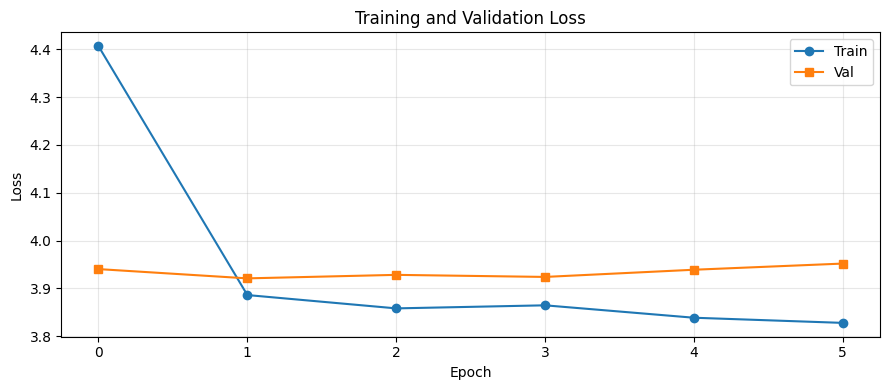

In [23]:
plt.figure(figsize=(9, 4))
plt.plot(train_losses, marker='o', label='Train')
plt.plot(val_losses,   marker='s', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('training_curves.png', dpi=120)
plt.show()

#### Blocking Unwanted Tokens
Creates a list of tokens that should not be generated during summary prediction. Special tokens like `<PAD>` and `<UNK>` are also included.

In [24]:
import scipy.special

BLOCKED = set()
for w, i in word2idx.items():
    if w.strip() == '' or all(ch in '.,!?;:\'"()-' for ch in w):
        BLOCKED.add(i)
BLOCKED.update({PAD_IDX, UNK_IDX})

print(f'Blocked token count : {len(BLOCKED)}')

Blocked token count : 6


#### Trigram Blocking
Helps prevent repetition in generated summaries. Checks the last two generated words (a bigram) and looks for previous occurrences of the same bigram in the sequence.

In [25]:
def trigram_block(generated):
    banned = set()
    if len(generated) >= 2:
        bigram = tuple(generated[-2:])
        for i in range(len(generated) - 2):
            if tuple(generated[i:i+2]) == bigram:
                banned.add(generated[i + 2])
    return banned

#### Beam Search Decoding
Generates summaries using beam search, which explores multiple possible word sequences and selects the best one. The input article is cleaned, converted into token IDs, padded, and passed through the encoder to obtain encoded representations. The decoding process then begins with the `<SOS>` token. The decoder predicts possible next words for all active beams. Several techniques are applied to improve quality like Blocking unwanted tokens, Minimum length restriction before allowing `<EOS>`, Repetition penalty to reduce repeated words, Trigram blocking to prevent repeating phrases, Top-k filtering to limit unlikely word choices. Each candidate sequence is scored using log probabilities and length normalization. The best sequences are kept until the summary is complete. Finally, the highest-scoring summary is selected and converted back into text.

In [26]:
def beam_search(article_text, beam_width=4, rep_penalty=2.0,
                length_alpha=0.7, min_len=8, top_k=50):

    cleaned = clean_text(article_text)
    ids     = [word2idx.get(w, UNK_IDX) for w in cleaned.split()][:MAX_INPUT_LEN]
    padded  = ids + [PAD_IDX] * (MAX_INPUT_LEN - len(ids))
    enc_in  = tf.constant([padded], dtype=tf.int32)

    enc_out, h0, c0 = encoder(enc_in, training=False)
    cov0 = tf.zeros([1, MAX_INPUT_LEN, 1])

    beams, completed = [(0.0, [SOS_IDX], h0, c0, cov0, False)], []

    for step in range(MAX_TARGET_LEN):
        if not beams:
            break
        n        = len(beams)
        toks_in  = tf.constant([[b[1][-1]] for b in beams], dtype=tf.int32)
        batch_h  = tf.concat([b[2] for b in beams], axis=0)
        batch_c  = tf.concat([b[3] for b in beams], axis=0)
        batch_cv = tf.concat([b[4] for b in beams], axis=0)
        enc_tile = tf.tile(enc_out, [n, 1, 1])

        logits, new_h, new_c, attn_w = decoder(
            toks_in, batch_h, batch_c, enc_tile,
            coverage=batch_cv, training=False
        )
        logits_np  = logits.numpy()
        new_cov_np = (batch_cv + attn_w).numpy()

        candidates = []
        for i, (lp, toks, _, _, _, done) in enumerate(beams):
            if done:
                completed.append((lp, toks))
                continue
            lg = logits_np[i].copy()
            for tid in BLOCKED:                  lg[tid] = -1e9
            if step < min_len:                   lg[EOS_IDX] = -1e9
            for tid in set(toks[1:]):            lg[tid] /= rep_penalty
            for tid in trigram_block(toks[1:]): lg[tid] = -1e9
            if top_k > 0:
                kth = np.partition(lg, -top_k)[-top_k]
                lg[lg < kth] = -1e9
            lp_arr = scipy.special.log_softmax(lg)
            for tid in np.argsort(lp_arr)[-beam_width:][::-1]:
                if lp_arr[tid] < -50:
                    continue
                is_done = int(tid) == EOS_IDX
                candidates.append((
                    lp + lp_arr[tid], toks + [int(tid)],
                    new_h[i:i+1], new_c[i:i+1],
                    tf.constant(new_cov_np[i:i+1]), is_done
                ))
        if not candidates:
            break
        candidates.sort(key=lambda x: x[0] / max(len(x[1]) ** length_alpha, 1), reverse=True)
        beams      = [c for c in candidates if not c[5]][:beam_width]
        completed += [c for c in candidates if c[5]]

    pool = completed if completed else beams
    if not pool:
        return clean_text(article_text).split('.')[0].strip() + '.'
    best = max(pool, key=lambda x: x[0] / max(len(x[1]) ** length_alpha, 1))
    out = ' '.join(idx2word.get(t, UNK) for t in best[1][1:]
                    if t not in (EOS_IDX, SOS_IDX, PAD_IDX))
    if len([w for w in out.split() if len(w) > 2]) < 4:
        return clean_text(article_text).split('.')[0].strip() + '.'
    return out

print('beam_search ready.')

beam_search ready.


#### Summary Generation Demo
Selects one article and its reference (true) summary from the test set. It prints the first part of the article for context, followed by the original reference summary. Generates a summary using the beam search decoding function and prints the model’s output.

In [27]:
demo_art = test_arts[0]
demo_ref = test_summs[0]

print('Article (first 350 chars):')
print(demo_art[:350])
print()
print('Reference summary:')
print(demo_ref)
print()
print('Beam search output:')
print(beam_search(demo_art))

Article (first 350 chars):
the palestinian authority officially became the 123rd member of the international criminal court on wednesday, a step that gives the court jurisdiction over alleged crimes in palestinian territories. the formal accession was marked with a ceremony at the hague, in the netherlands, where the court is based. the palestinians signed the icc's founding

Reference summary:
membership gives the icc jurisdiction over alleged crimes committed in palestinian territories since last june . israel and the united states opposed the move, which could open the door to war crimes investigations against israelis .

Beam search output:
the palestinian authority officially became the 123rd member of the international criminal court on wednesday, a step that gives the court jurisdiction over alleged crimes in palestinian territories.


#### Step-by-Step Greedy Decoding with Attention Tracking
test article is cleaned, converted into token IDs, padded, and passed through the encoder to obtain encoded representations. Decoding starts with the `<SOS>` token, and an empty coverage vector is initialized to track attention history.

In [28]:
cleaned = clean_text(test_arts[0])
ids = [word2idx.get(w, UNK_IDX) for w in cleaned.split()][:MAX_INPUT_LEN]
padded = ids + [PAD_IDX] * (MAX_INPUT_LEN - len(ids))
enc_in = tf.constant([padded], dtype=tf.int32)

enc_out, dec_h, dec_c = encoder(enc_in, training=False)
coverage = tf.zeros([1, MAX_INPUT_LEN, 1])
cur_tok = tf.constant([[SOS_IDX]], dtype=tf.int32)

attn_rows, out_words = [], []

for step in range(30):
    logits, dec_h, dec_c, attn_w = decoder(
        cur_tok, dec_h, dec_c, enc_out, coverage=coverage, training=False)
    coverage += attn_w
    lg = logits.numpy()[0]
    for tid in BLOCKED:
        lg[tid] = -1e9
    if step < 5:
        lg[EOS_IDX] = -1e9
    pred = int(np.argmax(lg))
    if pred in (EOS_IDX, PAD_IDX):
        break
    out_words.append(idx2word.get(pred, UNK))
    attn_rows.append(attn_w[0, :len(ids), 0].numpy())
    cur_tok = tf.constant([[pred]], dtype=tf.int32)

#### Attention Heatmap Visualization
If attention weights were recorded during decoding, they are converted into a matrix and displayed as a heatmap. The x-axis represents input words from the article, and the y-axis represents the generated summary words. Darker shades indicate stronger attention.

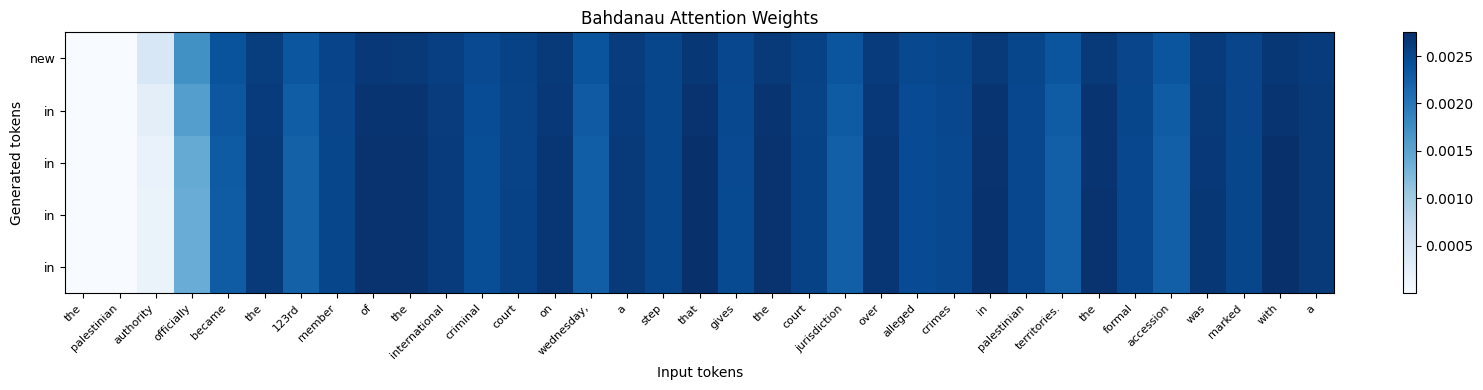

Heatmap saved.


In [29]:
if attn_rows:
    mat = np.array(attn_rows)
    in_words = cleaned.split()[:len(ids)]
    K = min(35, len(in_words))

    fig, ax = plt.subplots(figsize=(15, max(4, len(out_words) * 0.4)))
    im = ax.imshow(mat[:, :K], cmap='Blues', aspect='auto')
    ax.set_xticks(range(K))
    ax.set_xticklabels(in_words[:K], rotation=45, ha='right', fontsize=8)
    ax.set_yticks(range(len(out_words)))
    ax.set_yticklabels(out_words, fontsize=9)
    ax.set_xlabel('Input tokens')
    ax.set_ylabel('Generated tokens')
    ax.set_title('Bahdanau Attention Weights')
    plt.colorbar(im, fraction=0.02)
    plt.tight_layout()
    plt.savefig('attention_heatmap.png', dpi=120)
    plt.show()
    print('Heatmap saved.')
else:
    print('No output generated. Check model training.')

#### ROUGE Evaluation
ROUGE scorer is initialized to calculate ROUGE-1, ROUGE-2, and ROUGE-L scores.

In [30]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
N_EVAL = min(200, len(test_arts))
r1, r2, rL = [], [], []

print(f'Evaluating on {N_EVAL} test articles...')
t_start = time.time()

for i in tqdm(range(N_EVAL)):
    gen = beam_search(test_arts[i])
    sc  = scorer.score(test_summs[i], gen)
    r1.append(sc['rouge1'].fmeasure)
    r2.append(sc['rouge2'].fmeasure)
    rL.append(sc['rougeL'].fmeasure)

print(f'Evaluation time : {(time.time()-t_start)/60:.1f} min')
print()
print(f'ROUGE-1 : {np.mean(r1):.4f}')
print(f'ROUGE-2 : {np.mean(r2):.4f}')
print(f'ROUGE-L : {np.mean(rL):.4f}')
if np.mean(r1) >= 0.35:
    print('Target ROUGE-1 >= 0.35 reached.')
else:
    print('Below target. Try increasing TRAIN_SAMPLES or EPOCHS.')

Evaluating on 200 test articles...


100%|██████████| 200/200 [13:49<00:00,  4.15s/it]

Evaluation time : 13.8 min

ROUGE-1 : 0.2485
ROUGE-2 : 0.0849
ROUGE-L : 0.1844
Below target. Try increasing TRAIN_SAMPLES or EPOCHS.


#### Random Test Sample Evaluation

In [31]:
print('5 random test samples')

for idx in random.sample(range(N_EVAL), 5):
    gen = beam_search(test_arts[idx])
    sc  = scorer.score(test_summs[idx], gen)
    print(f'Article   : {test_arts[idx][:220]}...')
    print(f'Reference : {test_summs[idx]}')
    print(f'Generated : {gen}')
    print(f'ROUGE-1: {sc["rouge1"].fmeasure:.3f}  '
          f'ROUGE-2: {sc["rouge2"].fmeasure:.3f}  '
          f'ROUGE-L: {sc["rougeL"].fmeasure:.3f}')
    print('-' * 70)

5 random test samples
Article   : hip hop star nelly has been arrested on drug charges in tennessee after a state trooper pulled over the private bus in which he was traveling, authorities said. the 40 year old rapper from st. louis, who shot to fame 15 ...
Reference : state troopers say they found methamphetamine and marijuana on a bus carrying nelly and five others . nelly has been charged with felony possession of drugs .
Generated : hip hop star nelly has been arrested on drug charges in tennessee after a state trooper pulled over the private bus in which he was traveling, authorities said.
ROUGE-1: 0.377  ROUGE-2: 0.118  ROUGE-L: 0.151
----------------------------------------------------------------------
Article   : a judge this week sentenced a former tsa agent to six months in jail for secretly videotaping a female co worker while she was in the bathroom, prosecutors said. during the investigation, detectives with the metro nashvi...
Reference : former tsa agent daniel boykin, 

#### T5 Transformer Setup for Summarization
Pre-trained T5-small model for abstractive summarization using the Hugging Face Transformers library. T5 tokenizer converts text into tokens, and T5 model is loaded.

In [86]:
import torch
from transformers import T5TokenizerFast, T5ForConditionalGeneration

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
T5_MODEL = 't5-small'
T5_MAX_IN = 512
T5_MAX_OUT = 128
T5_TRAIN_N = 20000
T5_VAL_N = 10000
T5_TEST_N  = 10
PREFIX = 'summarize: '
T5_OUT_DIR = './t5_summarizer'

os.makedirs(T5_OUT_DIR, exist_ok=True)

t5_tokenizer = T5TokenizerFast.from_pretrained(T5_MODEL)
t5_model = T5ForConditionalGeneration.from_pretrained(T5_MODEL).to(DEVICE)

n_params = sum(p.numel() for p in t5_model.parameters())
print(f'Device : {DEVICE}')
print(f'Model : {T5_MODEL}  ({n_params/1e6:.0f}M parameters)')

Loading weights:   0%|          | 0/131 [00:00<?, ?it/s]

Device : cuda
Model : t5-small  (61M parameters)


#### Preparing Hugging Face Dataset Splits for T5
Dataset objects (t5_train_raw, t5_val_raw, t5_test_raw) are ready to be tokenized and used for training, validation, and evaluation.

In [87]:
from datasets import Dataset

def build_hf_split(hf_split, n):
    rows = {'article': [], 'highlights': []}
    for i in range(min(n, len(hf_split))):
        rows['article'].append(hf_split[i]['article'])
        rows['highlights'].append(hf_split[i]['highlights'].replace('\n', ' '))
    return Dataset.from_dict(rows)

t5_train_raw = build_hf_split(train_raw, T5_TRAIN_N)
t5_val_raw = build_hf_split(val_raw, T5_VAL_N)
t5_test_raw = build_hf_split(test_raw, T5_TEST_N)

print(f'Splits train: {len(t5_train_raw):,}, val: {len(t5_val_raw):,}, test: {len(t5_test_raw):,}')

Splits train: 20,000, val: 10,000, test: 10


#### Tokenizing T5 Dataset
Each article is prepended with the prefix "summarize: " to indicate the task to the model. Tokenizer truncates long sequences and converts both inputs (articles) and targets (summaries) into token IDs.

In [88]:
def tokenize_fn(batch):
    inputs  = [PREFIX + a for a in batch['article']]
    enc = t5_tokenizer(inputs, max_length=T5_MAX_IN, truncation=True, padding=False)
    labels = t5_tokenizer(batch['highlights'], max_length=T5_MAX_OUT, truncation=True, padding=False)
    enc['labels'] = labels['input_ids']
    return enc

drop_cols = ['article', 'highlights']
t5_train = t5_train_raw.map(tokenize_fn, batched=True, remove_columns=drop_cols)
t5_val = t5_val_raw.map(tokenize_fn,   batched=True, remove_columns=drop_cols)
t5_test = t5_test_raw.map(tokenize_fn,  batched=True, remove_columns=drop_cols)

print('Tokenization done.')

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Tokenization done.


#### ROUGE Metric for T5 Evaluation
ROUGE evaluation for the T5 model using the evaluate library.

In [35]:
import evaluate
import numpy as np

rouge_metric = evaluate.load('rouge')

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    preds = np.where(preds != -100, preds, t5_tokenizer.pad_token_id)
    labels = np.where(labels != -100, labels, t5_tokenizer.pad_token_id)
    decoded_preds  = [p.strip() for p in t5_tokenizer.batch_decode(preds,  skip_special_tokens=True)]
    decoded_labels = [l.strip() for l in t5_tokenizer.batch_decode(labels, skip_special_tokens=True)]
    result = rouge_metric.compute(predictions=decoded_preds,
                                  references=decoded_labels, use_stemmer=True)
    return {k: round(v, 4) for k, v in result.items()}

print('ROUGE metric loaded.')

ROUGE metric loaded.


#### T5 Training Setup with Hugging Face Trainer
Data collator handles dynamic padding for inputs and labels. Seq2SeqTrainer ties together the model, datasets, collator, metric computation, and callbacks.

In [36]:
from transformers import (DataCollatorForSeq2Seq, Seq2SeqTrainer,
                          Seq2SeqTrainingArguments, EarlyStoppingCallback)

collator = DataCollatorForSeq2Seq(t5_tokenizer, model=t5_model,
                                  label_pad_token_id=-100, pad_to_multiple_of=8)

args = Seq2SeqTrainingArguments(
    output_dir = T5_OUT_DIR,
    num_train_epochs = 3,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size  = 8,
    gradient_accumulation_steps = 4,
    learning_rate = 5e-4,
    warmup_steps = int(0.05*(T5_TRAIN_N/(8*4)*3)),
    weight_decay = 0.01,
    lr_scheduler_type = 'cosine',
    eval_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True,
    metric_for_best_model = 'rouge1',
    greater_is_better = True,
    predict_with_generate = True,
    generation_max_length = T5_MAX_OUT,
    logging_steps = 100,
    report_to = 'none',
    fp16 = (DEVICE == 'cuda'),
    seed = 42,
)

trainer = Seq2SeqTrainer(
    model = t5_model,
    args = args,
    train_dataset = t5_train,
    eval_dataset = t5_val,
    data_collator = collator,
    compute_metrics = compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=2)],
)

print('Trainer configured.')
print(f'  Effective batch size : {8 * 4}')

Trainer configured.
  Effective batch size : 32


#### T5 Fine-Tuning
trainer.train() method handles the entire training loop

In [37]:
print('T5 fine-tuning')
t_t5 = time.time()
trainer.train()
print(f'Fine-tuning done in {(time.time()-t_t5)/60:.1f} min')

T5 fine-tuning


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,8.353729,2.030501,0.383300,0.168400,0.272100,0.272000
2,7.879448,2.021023,0.390300,0.173200,0.276400,0.276400
3,7.491169,2.024621,0.391800,0.173600,0.276800,0.276700


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


Fine-tuning done in 125.2 min


#### T5 Model Evaluation
Fine-tuned T5 model on the test set using ROUGE metrics. Average ROUGE scores across all test samples are reported

In [89]:
from rouge_score import rouge_scorer as rs_lib

scorer_t5 = rs_lib.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
t5_model.eval()

r1_t5, r2_t5, rL_t5 = [], [], []

print(f'Evaluating T5 on {len(t5_test_raw)} articles...')
t_eval = time.time()

for ex in tqdm(t5_test_raw):
    inp = t5_tokenizer(PREFIX + ex['article'], max_length=T5_MAX_IN,
                       truncation=True, return_tensors='pt').to(DEVICE)
    with torch.no_grad():
        out_ids = t5_model.generate(**inp, max_new_tokens=T5_MAX_OUT, num_beams=4,
                                    early_stopping=True, no_repeat_ngram_size=3,
                                    length_penalty=2.0)
    gen = t5_tokenizer.decode(out_ids[0], skip_special_tokens=True).strip()
    ref = ex['highlights'].replace('\n', ' ').strip()
    sc = scorer_t5.score(ref, gen)
    r1_t5.append(sc['rouge1'].fmeasure)
    r2_t5.append(sc['rouge2'].fmeasure)
    rL_t5.append(sc['rougeL'].fmeasure)

print(f'Evaluation time : {(time.time()-t_eval)/60:.1f} min')
print()
print(f'ROUGE-1 : {np.mean(r1_t5):.4f}')
print(f'ROUGE-2 : {np.mean(r2_t5):.4f}')
print(f'ROUGE-L : {np.mean(rL_t5):.4f}')

Evaluating T5 on 10 articles...


100%|██████████| 10/10 [00:09<00:00,  1.07it/s]

Evaluation time : 0.2 min

ROUGE-1 : 0.3956
ROUGE-2 : 0.1696
ROUGE-L : 0.2672


#### T5 Sample Summaries
5 randomly selected test examples to inspect the quality of T5-generated summaries

In [39]:
print('T5 sample summaries')

for idx in random.sample(range(len(t5_test_raw)), 5):
    ex  = t5_test_raw[idx]
    ref = ex['highlights'].replace('\n', ' ').strip()
    inp = t5_tokenizer(PREFIX + ex['article'], max_length=T5_MAX_IN,
                       truncation=True, return_tensors='pt').to(DEVICE)
    with torch.no_grad():
        out_ids = t5_model.generate(**inp, max_new_tokens=T5_MAX_OUT, num_beams=4,
                                    early_stopping=True, no_repeat_ngram_size=3,
                                    length_penalty=2.0)
    gen = t5_tokenizer.decode(out_ids[0], skip_special_tokens=True).strip()
    sc  = scorer_t5.score(ref, gen)
    print(f'Article : {ex["article"][:220]}...')
    print(f'Reference : {ref}')
    print(f'Generated : {gen}')
    print(f'ROUGE-1: {sc["rouge1"].fmeasure:.3f}  '
          f'ROUGE-2: {sc["rouge2"].fmeasure:.3f}  '
          f'ROUGE-L: {sc["rougeL"].fmeasure:.3f}')

T5 sample summaries
Article   : Catania, Italy (CNN)The boat that sank in the Mediterranean over the weekend with hundreds of migrants on board may have capsized after being touched or swamped by a cargo ship that came to its aid, a U.N. official said....
Reference : Shipping company representative denies cargo ship caused the capsizing . UNHCR spokeswoman tells CNN that a cargo ship may have touched the migrant boat . Italian authorities have arrested two survivors on suspicion of human trafficking .
Generated : Carlotta Asami, a U.N. refugee agency spokeswoman to CNN. She and her colleagues had spoken to multiple survivors from the disaster. Italian authorities say only 28 survivors were rescued and 24 bodies have been recovered.
ROUGE-1: 0.229  ROUGE-2: 0.029  ROUGE-L: 0.171
Article   : (CNN)The FBI has confirmed that one of its most wanted terrorists, the Malaysian bomb maker known as Marwan, was killed in an otherwise disastrous raid in the Philippines in January. Marwan, whose re

#### Reference
- [https://medium.com/@harishraj_4620/nlp-from-scratch-part-3-seqtoseq-encoder-decoder-model-with-bahdanau-attention-91c5df069d44](https://medium.com/@harishraj_4620/nlp-from-scratch-part-3-seqtoseq-encoder-decoder-model-with-bahdanau-attention-91c5df069d44)
- [https://d2l.ai/chapter_attention-mechanisms-and-transformers/bahdanau-attention.html](https://d2l.ai/chapter_attention-mechanisms-and-transformers/bahdanau-attention.html)

#### Conclusion
#### Encoder Decoder with Bahdanau attention
ROUGE-1 : 0.2485
ROUGE-2 : 0.0849
ROUGE-L : 0.1844

#### T5-small Fine tuning
ROUGE-1 : 0.3956
ROUGE-2 : 0.1696
ROUGE-L : 0.2672